In [86]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [87]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [88]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


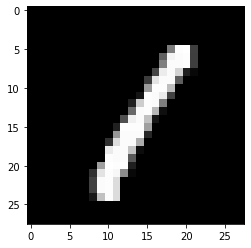

In [89]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

In [90]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,shuffle = False)

In [91]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()
print('Shapes of the minibatch of images: {}'.format(images.shape))
print('Shapes of the minibatch of labels: {}'.format(labels.shape))

Shapes of the minibatch of images: torch.Size([100, 1, 28, 28])
Shapes of the minibatch of labels: torch.Size([100])


In [92]:
x = images.view(-1, 28*28)
print('The shape of input x: {}'.format(x.shape))

The shape of input x: torch.Size([100, 784])


In [93]:
W = torch.rand(784, 10)/np.sqrt(784) #Randomly initialiizes W 
W.requires_grad_()
b = torch.zeros(10, requires_grad = True) #Initialize bias b as zeroes

In [94]:
y = torch.matmul(x,W) + b

In [95]:
print(y[0,:])

tensor([1.0726, 1.2131, 1.1007, 1.1875, 1.3039, 1.0592, 1.1024, 1.1506, 1.1730,
        1.2393], grad_fn=<SliceBackward>)


In [96]:
#option 1 manually
py_eq = torch.exp(y)/torch.sum(torch.exp(y),dim = 1,keepdim=True)
print('py[0] from equation: {}'.format(py_eq[0]))

#option 2 which is determined by softmax function in torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print('py[0] from torch.nn.functinal: {}'.format(py[0]))

py[0] from equation: tensor([0.0913, 0.1051, 0.0940, 0.1025, 0.1151, 0.0901, 0.0941, 0.0988, 0.1010,
        0.1079], grad_fn=<SelectBackward>)
py[0] from torch.nn.functinal: tensor([0.0913, 0.1051, 0.0940, 0.1025, 0.1151, 0.0901, 0.0941, 0.0988, 0.1010,
        0.1079], grad_fn=<SelectBackward>)


In [97]:
print(labels.shape)

torch.Size([100])


In [98]:
#option 1 matematical equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])    #𝐻𝑦′(𝑦)=−∑𝑖𝑦′𝑖log(𝑦𝑖)
print('Cross entropy from equation: {}'.format(cross_entropy_eq))

#option 2 cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print('cross entropy using torch.nn.functional.cross_entropy: {}'.format(cross_entropy))

Cross entropy from equation: 2.3076353073120117
cross entropy using torch.nn.functional.cross_entropy: 2.3076353073120117


In [99]:
optimize = torch.optim.SGD([W,b],lr=0.1)

In [100]:
cross_entropy.backward()

In [101]:
b.grad

tensor([-0.0054,  0.0019,  0.0084,  0.0233, -0.0058, -0.0205, -0.0090, -0.0634,
         0.0346,  0.0360])

In [102]:
optimize.step()

In [103]:
b

tensor([ 0.0005, -0.0002, -0.0008, -0.0023,  0.0006,  0.0020,  0.0009,  0.0063,
        -0.0035, -0.0036], requires_grad=True)

In [104]:
print('b.grad before zero_grad(): {}'.format(b.grad))
optimize.zero_grad()
print('b.grad after zero_grad(): {}'.format(b.grad))

b.grad before zero_grad(): tensor([-0.0054,  0.0019,  0.0084,  0.0233, -0.0058, -0.0205, -0.0090, -0.0634,
         0.0346,  0.0360])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### Model training for 60000 example datasets

In [108]:
for images, labels in tqdm(train_loader):
    optimize.zero_grad()
    
    x = images.view(-1,28*28)
    y = torch.matmul(x,W)+b
    cross_entropy = F.cross_entropy(y,labels)
    cross_entropy.backward()
    optimize.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [111]:
correct = 0
total = len(mnist_test)
with torch.no_grad():
    for images,labels in tqdm(test_loader):
        x = images.view(-1,28*28)
        y = torch.matmul(x,W)+b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions==labels).float())
        
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9125999808311462


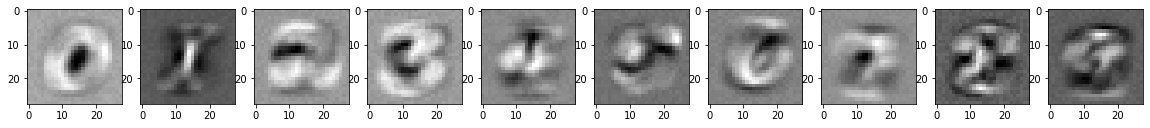

In [113]:
fig, ax = plt.subplots(1, 10, figsize=(20,2))

for digits in range(10):
    ax[digits].imshow(W[:,digits].detach().view(28,28), cmap='gray')